# NLP on South Carolina Food Reviews

The goal of this notebook is to do some rudimentary NLP on Reviews on South Carolina

In [33]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import spacy
import itertools as it
%matplotlib inline 
import warnings
warnings.simplefilter(action='ignore')

# NLP imports 
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from gensim import models, corpora
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from collections import Counter
from langdetect import detect
from collections import Counter
from textblob import TextBlob
import pyLDAvis.gensim

## Inspecting the Data

In [3]:
data = pd.read_csv("food_reviews_sc")

In [4]:
data.head(50)

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,name,...,address,city,state,postal_code,latitude,longitude,review_count,is_open,categories,avg_stars
0,-6e0liTvH5EoB4HuncuQgA,TgDVK5GGEVWqIQB1klOwOQ,Ow07iTOW_JUer07MWNhazg,5,2017-09-02,My husband and I happened to drive by BIG FOOD...,0,0,0,"""Small Bar Fort Mill""",...,"""3415 Hwy 51 N""",Fort Mill,SC,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0
1,-6e0liTvH5EoB4HuncuQgA,WsnsRDe7Ywl5FC7bALCBMA,nFS3GfDeOOzg-bXKuNNHsA,5,2017-08-01,First time great food and service will be goin...,0,0,0,"""Small Bar Fort Mill""",...,"""3415 Hwy 51 N""",Fort Mill,SC,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0
2,-6e0liTvH5EoB4HuncuQgA,8gkZ2V9YzsM9A3r6Lj9zrQ,M3ncFIlEfaSdSpoiMINwBA,4,2017-06-21,It's a bar. It's small. It's Small Bar! It's c...,1,1,1,"""Small Bar Fort Mill""",...,"""3415 Hwy 51 N""",Fort Mill,SC,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0
3,-6e0liTvH5EoB4HuncuQgA,UyD3TRVYYMCynpkBuR9CcQ,T81BRLNvCpRkgVtYyabImQ,4,2017-09-12,Great little bar in Fort Mill. We went for lun...,0,0,0,"""Small Bar Fort Mill""",...,"""3415 Hwy 51 N""",Fort Mill,SC,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0
4,-6e0liTvH5EoB4HuncuQgA,eAsxdJilerKbjmVd2FkDVQ,QKm7NuvVMmvWHKmW7blABg,5,2017-06-22,Small Bar is great! Super cold beer and the p...,0,0,1,"""Small Bar Fort Mill""",...,"""3415 Hwy 51 N""",Fort Mill,SC,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0
5,-6e0liTvH5EoB4HuncuQgA,hqE3shecmEutpV92IY9dZQ,9RIECSrcR1b_JgqQxe8ZcQ,5,2017-11-05,"I love this place, it just feels right. Excell...",0,0,0,"""Small Bar Fort Mill""",...,"""3415 Hwy 51 N""",Fort Mill,SC,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0
6,-6e0liTvH5EoB4HuncuQgA,clffFSUbDa_ZCdqrdO5FpQ,3kRvuw-shQgCbVdamuXinw,1,2017-12-01,Have gone to one in Stallings a few times and ...,0,0,0,"""Small Bar Fort Mill""",...,"""3415 Hwy 51 N""",Fort Mill,SC,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0
7,-QKKkUEQhDVndxZDT9SovQ,GSAtU63AR_LT00m0JQbaVw,IZXnSMdOkVdFH-mw6zQBbA,3,2012-05-21,"Visited Los Aztecas for lunch today, just to t...",3,0,0,"""Los Aztecas""",...,"""100 Fort Mill Sq""",Fort Mill,SC,29715.0,34.990158,-80.951638,16.0,0.0,Mexican;Restaurants,4.0
8,-QKKkUEQhDVndxZDT9SovQ,_s95GeofuiR1aps2Kk0gng,_KptDymJrxRDCxEh16czzA,5,2014-03-28,We moved to Fort Mill this past July. This re...,0,0,0,"""Los Aztecas""",...,"""100 Fort Mill Sq""",Fort Mill,SC,29715.0,34.990158,-80.951638,16.0,0.0,Mexican;Restaurants,4.0
9,-QKKkUEQhDVndxZDT9SovQ,a5tHGnS__O20XN_Qa_BHYA,3LWXSj487abbIKZs46qG0Q,5,2013-07-21,Food is awesome been going here since high sch...,0,0,0,"""Los Aztecas""",...,"""100 Fort Mill Sq""",Fort Mill,SC,29715.0,34.990158,-80.951638,16.0,0.0,Mexican;Restaurants,4.0


In [5]:
data["categories"].unique()

array(['Restaurants;Bars;Pubs;Sports Bars;Nightlife',
       'Mexican;Restaurants',
       'Nightlife;Bars;American (Traditional);Active Life;Golf;Restaurants',
       'Chicken Wings;Seafood;Sports Bars;Restaurants;Nightlife;American (Traditional);Bars',
       'Nightlife;American (New);Bars;Restaurants;Sports Bars',
       'Fast Food;Restaurants;Chicken Wings;Salad',
       'Restaurants;Barbeque', 'Fast Food;Restaurants',
       'Food;Restaurants;Ice Cream & Frozen Yogurt;American (Traditional);Burgers;Sandwiches',
       'Pubs;Bars;Restaurants;Nightlife;American (Traditional);Sports Bars',
       'American (New);Restaurants',
       'American (New);Restaurants;American (Traditional);Southern;Sandwiches',
       'American (Traditional);Restaurants;Delis;Sandwiches',
       'Greek;American (New);Restaurants',
       'Restaurants;Fast Food;Burgers',
       'Restaurants;American (Traditional);Steakhouses',
       'German;Specialty Food;Ethnic Food;Restaurants;Grocery;Food',
       'Resta

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6808 entries, 0 to 6807
Data columns (total 21 columns):
business_id     6808 non-null object
review_id       6808 non-null object
user_id         6808 non-null object
stars           6808 non-null int64
date            6808 non-null object
text            6808 non-null object
useful          6808 non-null int64
funny           6808 non-null int64
cool            6808 non-null int64
name            6808 non-null object
neighborhood    4 non-null object
address         6808 non-null object
city            6808 non-null object
state           6808 non-null object
postal_code     6801 non-null float64
latitude        6808 non-null float64
longitude       6808 non-null float64
review_count    6808 non-null float64
is_open         6808 non-null float64
categories      6808 non-null object
avg_stars       6808 non-null float64
dtypes: float64(6), int64(4), object(11)
memory usage: 1.1+ MB


## General Cleaning of the Data

Here, We will be dropping all features we will not be using in our analysis

In [7]:
data.columns

Index(['business_id', 'review_id', 'user_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool', 'name', 'neighborhood', 'address', 'city',
       'state', 'postal_code', 'latitude', 'longitude', 'review_count',
       'is_open', 'categories', 'avg_stars'],
      dtype='object')

In [8]:
cols_to_drop = ["neighborhood", "postal_code", "address"]

# dropping neighborhood 
data.drop(cols_to_drop, axis=1, inplace=True)

# # dropping restaurants that are no longer open
# data = data.drop(data[data["is_open"] != 1.0].index)

In [9]:
data.head()

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,name,city,state,latitude,longitude,review_count,is_open,categories,avg_stars
0,-6e0liTvH5EoB4HuncuQgA,TgDVK5GGEVWqIQB1klOwOQ,Ow07iTOW_JUer07MWNhazg,5,2017-09-02,My husband and I happened to drive by BIG FOOD...,0,0,0,"""Small Bar Fort Mill""",Fort Mill,SC,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0
1,-6e0liTvH5EoB4HuncuQgA,WsnsRDe7Ywl5FC7bALCBMA,nFS3GfDeOOzg-bXKuNNHsA,5,2017-08-01,First time great food and service will be goin...,0,0,0,"""Small Bar Fort Mill""",Fort Mill,SC,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0
2,-6e0liTvH5EoB4HuncuQgA,8gkZ2V9YzsM9A3r6Lj9zrQ,M3ncFIlEfaSdSpoiMINwBA,4,2017-06-21,It's a bar. It's small. It's Small Bar! It's c...,1,1,1,"""Small Bar Fort Mill""",Fort Mill,SC,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0
3,-6e0liTvH5EoB4HuncuQgA,UyD3TRVYYMCynpkBuR9CcQ,T81BRLNvCpRkgVtYyabImQ,4,2017-09-12,Great little bar in Fort Mill. We went for lun...,0,0,0,"""Small Bar Fort Mill""",Fort Mill,SC,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0
4,-6e0liTvH5EoB4HuncuQgA,eAsxdJilerKbjmVd2FkDVQ,QKm7NuvVMmvWHKmW7blABg,5,2017-06-22,Small Bar is great! Super cold beer and the p...,0,0,1,"""Small Bar Fort Mill""",Fort Mill,SC,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0


Now, we need to identify the language the reviews are written in, and then decide whether or not to drop them. 

In [10]:
# checking out the types of languages we are dealing with
lang = []
for text in data["text"]:
    lang.append(detect(text))

print(Counter(lang))

Counter({'en': 6803, 'it': 2, 'de': 1, 'hr': 1, 'pt': 1})


In [11]:
# creating a language identifying feature 
data["lang"] = data["text"].apply(lambda x: detect(x))

In [12]:
# dropping reviews that arent english 
data = data.drop(data[data["lang"] != 'en'].index)

## Feature Creation 

Here, we will be creating additional features we may wish to use for further exploration and analysis

In [13]:
# creating a length of review feature 
data["review_length"] = data["text"].apply(len)

In [14]:
# creating a sentiment score feature 
data["sentiment_score"] = data["text"].apply(lambda x: TextBlob(x).polarity)

In [15]:
# creating a subjectivity score feature
data["subjectivity_score"] = data["text"].apply(lambda x: TextBlob(x).subjectivity)

In [16]:
data.head()

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,name,...,latitude,longitude,review_count,is_open,categories,avg_stars,lang,review_length,sentiment_score,subjectivity_score
0,-6e0liTvH5EoB4HuncuQgA,TgDVK5GGEVWqIQB1klOwOQ,Ow07iTOW_JUer07MWNhazg,5,2017-09-02,My husband and I happened to drive by BIG FOOD...,0,0,0,"""Small Bar Fort Mill""",...,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,en,910,0.251736,0.488889
1,-6e0liTvH5EoB4HuncuQgA,WsnsRDe7Ywl5FC7bALCBMA,nFS3GfDeOOzg-bXKuNNHsA,5,2017-08-01,First time great food and service will be goin...,0,0,0,"""Small Bar Fort Mill""",...,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,en,101,0.360000,0.486667
2,-6e0liTvH5EoB4HuncuQgA,8gkZ2V9YzsM9A3r6Lj9zrQ,M3ncFIlEfaSdSpoiMINwBA,4,2017-06-21,It's a bar. It's small. It's Small Bar! It's c...,1,1,1,"""Small Bar Fort Mill""",...,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,en,1832,0.122175,0.463527
3,-6e0liTvH5EoB4HuncuQgA,UyD3TRVYYMCynpkBuR9CcQ,T81BRLNvCpRkgVtYyabImQ,4,2017-09-12,Great little bar in Fort Mill. We went for lun...,0,0,0,"""Small Bar Fort Mill""",...,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,en,103,0.103125,0.812500
4,-6e0liTvH5EoB4HuncuQgA,eAsxdJilerKbjmVd2FkDVQ,QKm7NuvVMmvWHKmW7blABg,5,2017-06-22,Small Bar is great! Super cold beer and the p...,0,0,1,"""Small Bar Fort Mill""",...,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,en,330,0.424427,0.726667


In [17]:
data.columns

Index(['business_id', 'review_id', 'user_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool', 'name', 'city', 'state', 'latitude',
       'longitude', 'review_count', 'is_open', 'categories', 'avg_stars',
       'lang', 'review_length', 'sentiment_score', 'subjectivity_score'],
      dtype='object')

## General EDA Through Visualizations 

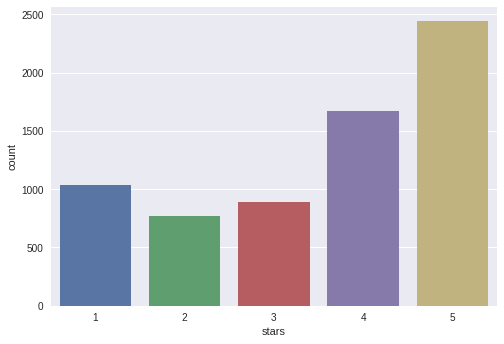

In [18]:
# distribution of star raitings in our dataset 
sns.set(style="darkgrid")
ax = sns.countplot(x="stars", data=data);

**Observations**: 

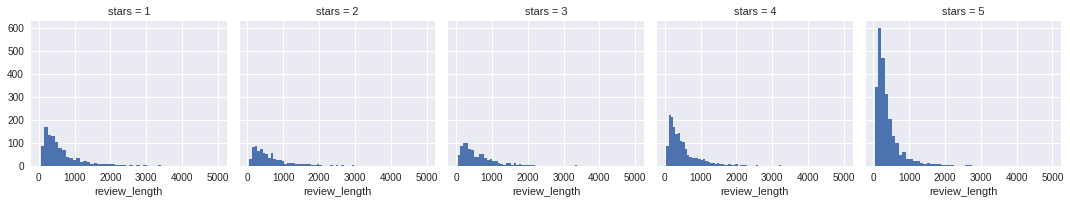

In [19]:
# seeign how review length changed by star raiting 
g = sns.FacetGrid(data=data, col='stars')
g.map(plt.hist, 'review_length', bins=50);

**Observations**: 

In [20]:
mask = ["useful", "funny", "cool", "review_length", "sentiment_score", "subjectivity_score", "stars"]

In [21]:
data_feat = data[mask]

In [22]:
stars = data_feat.groupby('stars').mean()
star = stars.corr()
star

,useful,funny,cool,review_length,sentiment_score,subjectivity_score
useful,1.000000,0.961582,-0.538994,0.865955,-0.951351,-0.942759
funny,0.961582,1.000000,-0.316636,0.915711,-0.863255,-0.946299
cool,-0.538994,-0.316636,1.000000,-0.404970,0.720283,0.517585
review_length,0.865955,0.915711,-0.404970,1.000000,-0.847761,-0.978572
sentiment_score,-0.951351,-0.863255,0.720283,-0.847761,1.000000,0.935871
subjectivity_score,-0.942759,-0.946299,0.517585,-0.978572,0.935871,1.000000


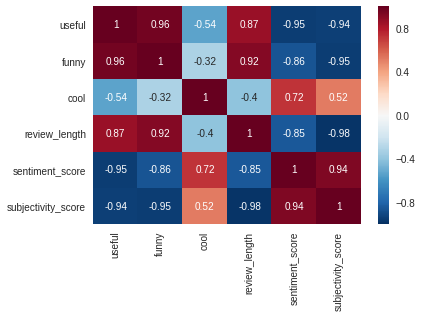

In [34]:
sns.heatmap(data=stars.corr(), annot=True);

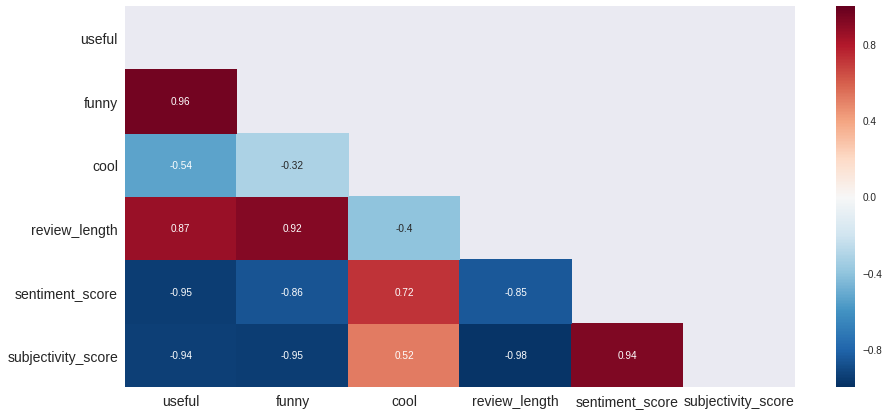

In [35]:
# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(15,7))

# Generates a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(star, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generating our correlation heatmap
ax = sns.heatmap(star, mask=mask, ax=ax, annot = True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show();

**Observations**:

Things to do
- How sentiment affects stars; that whole criss cross match (stars)
- 

In [25]:
data.head()

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,name,...,latitude,longitude,review_count,is_open,categories,avg_stars,lang,review_length,sentiment_score,subjectivity_score
0,-6e0liTvH5EoB4HuncuQgA,TgDVK5GGEVWqIQB1klOwOQ,Ow07iTOW_JUer07MWNhazg,5,2017-09-02,My husband and I happened to drive by BIG FOOD...,0,0,0,"""Small Bar Fort Mill""",...,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,en,910,0.251736,0.488889
1,-6e0liTvH5EoB4HuncuQgA,WsnsRDe7Ywl5FC7bALCBMA,nFS3GfDeOOzg-bXKuNNHsA,5,2017-08-01,First time great food and service will be goin...,0,0,0,"""Small Bar Fort Mill""",...,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,en,101,0.360000,0.486667
2,-6e0liTvH5EoB4HuncuQgA,8gkZ2V9YzsM9A3r6Lj9zrQ,M3ncFIlEfaSdSpoiMINwBA,4,2017-06-21,It's a bar. It's small. It's Small Bar! It's c...,1,1,1,"""Small Bar Fort Mill""",...,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,en,1832,0.122175,0.463527
3,-6e0liTvH5EoB4HuncuQgA,UyD3TRVYYMCynpkBuR9CcQ,T81BRLNvCpRkgVtYyabImQ,4,2017-09-12,Great little bar in Fort Mill. We went for lun...,0,0,0,"""Small Bar Fort Mill""",...,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,en,103,0.103125,0.812500
4,-6e0liTvH5EoB4HuncuQgA,eAsxdJilerKbjmVd2FkDVQ,QKm7NuvVMmvWHKmW7blABg,5,2017-06-22,Small Bar is great! Super cold beer and the p...,0,0,1,"""Small Bar Fort Mill""",...,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,en,330,0.424427,0.726667


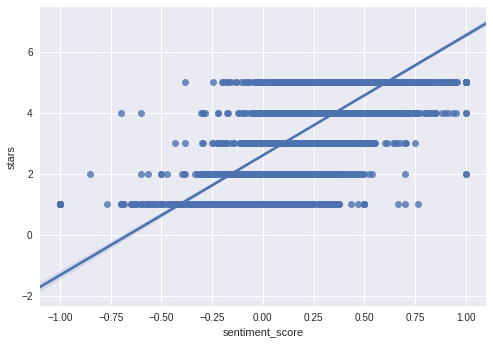

In [26]:
# plotting sentiment score vs stars 
ax = sns.regplot(x="sentiment_score", y="stars", data=data)

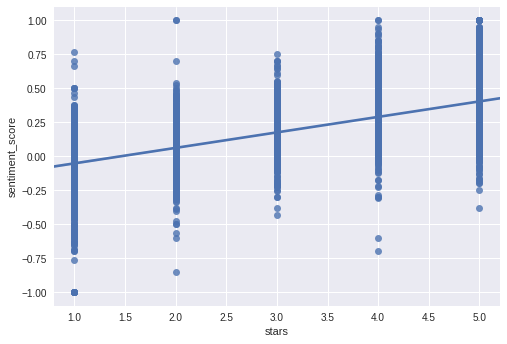

In [27]:
ax = sns.regplot(x="stars", y="sentiment_score", data=data)

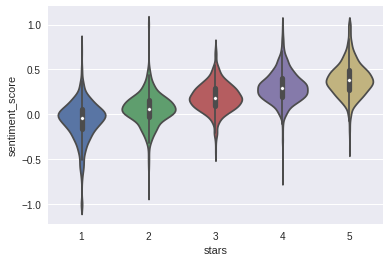

In [36]:
ax = sns.violinplot(x="stars", y="sentiment_score", data=data)

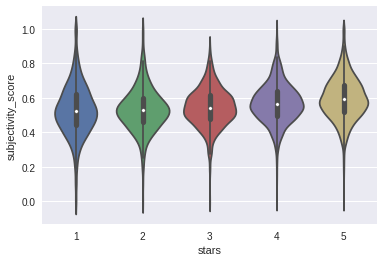

In [37]:
ax = sns.violinplot(x="stars", y="subjectivity_score", data=data)

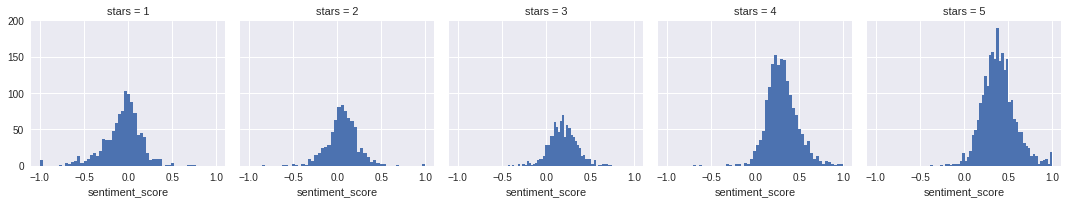

In [31]:
# still checking sentiment score and star raiting
g = sns.FacetGrid(data=data, col='stars')
g.map(plt.hist, 'sentiment_score', bins=50);

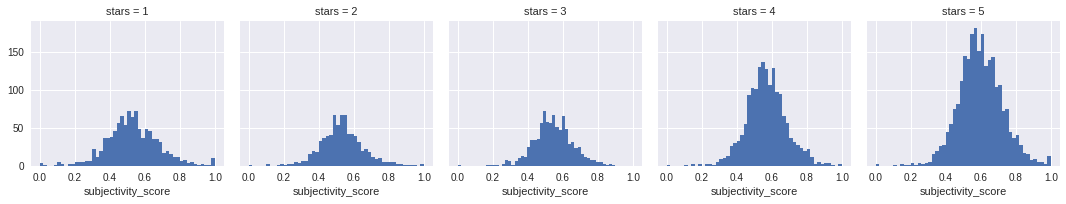

In [32]:
g = sns.FacetGrid(data=data, col='stars')
g.map(plt.hist, 'subjectivity_score', bins=50);

Let's create a new feature where its 4 stars and above vs under four stars. My reasoning is the following: 
- 4 and above is pretty positive. Indicates a rather good dining experience with little to no qualms 
- 3 and below means that there was something "less than ideal" about the dining experience. It is from this category that we will be able to pull the key patron "pain points" via topic modeling and other methods. 

In [ ]:
data["above_4_stars"] = 

In [45]:
# plot review length and subjectivity score 
# reveiw length cs sentiment score, hue is stars 
# ax = sns.regplot(x="review_length", y="sentiment_score", hue="stars", data=data)

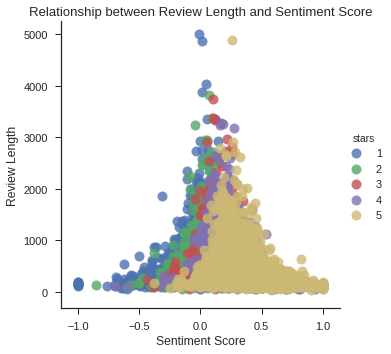

In [50]:
# Setting style of scatterplot
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# Create scatterplot of dataframe
sns.lmplot('sentiment_score',
           'review_length', 
           data=data,
           fit_reg=False,
           hue="stars",
           scatter_kws={"marker": "D", 
                        "s": 100}) 

plt.title('Relationship between Review Length and Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Review Length');

In [44]:
# g = sns.FacetGrid(data, hue="stars")
# g = g.map(sns.kdeplot, "review_length")

# g = sns.FacetGrid(data, hue="stars")
# g = g.map(sns.distplot, "review_length")

In [51]:
# dropping neighborhood since kind of useless 
# X = data.drop("neighborhood", axis=1, inplace=True)
y = data["stars"]

In [7]:
detect(data["text"][0])

'en'

In [8]:
# making sure we are dealing with english 

lang = {}

for text in data["text"]:
    lang.append(detect(text))
    

In [10]:
langs = set(lang)

In [11]:
langs

{'de', 'en', 'hr', 'it', 'pt'}

hr = Croatian
it = Italian 
pt = Portuguese 
de = German 

In [16]:
Counter(lang)

Counter({'de': 1, 'en': 6804, 'hr': 1, 'it': 1, 'pt': 1})

## Recap viz

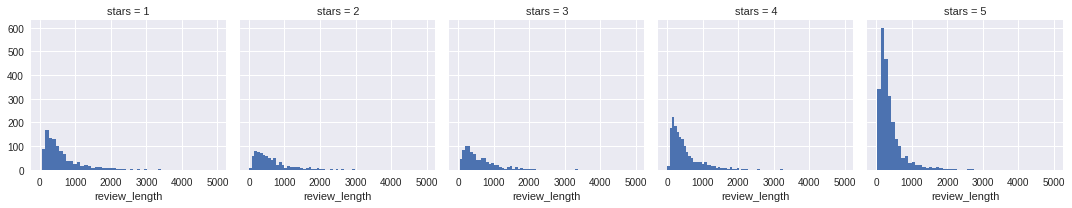

In [97]:
g = sns.FacetGrid(data=data, col='stars')
g.map(plt.hist, 'Review Length', bins=50);

The clear trend here is that reviews with more stars have longer text. 

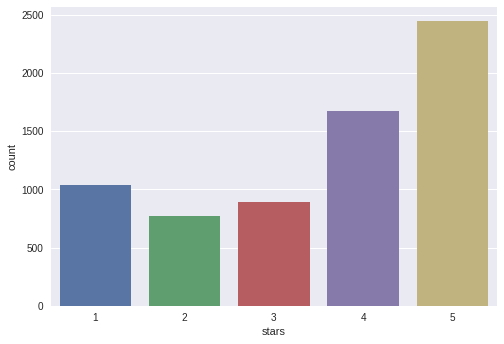

In [37]:
sns.set(style="darkgrid")
ax = sns.countplot(x="stars", data=data)

In [38]:
data["text"]

0       My husband and I happened to drive by BIG FOOD...
1       First time great food and service will be goin...
2       It's a bar. It's small. It's Small Bar! It's c...
3       Great little bar in Fort Mill. We went for lun...
4       Small Bar is great!  Super cold beer and the p...
5       I love this place, it just feels right. Excell...
6       Have gone to one in Stallings a few times and ...
7       Visited Los Aztecas for lunch today, just to t...
8       We moved to Fort Mill this past July.  This re...
9       Food is awesome been going here since high sch...
10      I live near this place and we probably eat the...
11      One of our favorite spots in Fort Mill.  Very ...
12      I always kept seeing this place on my driving ...
13      Love this place! There's also one in Tega Cay....
14      Best Mexican food in the Fort Mill\/Tega Cay a...
15      Fast service but food is kinda meh. I would sa...
16      Food came out in five minutes!  Prompt service...
17      The lu

## Sentiment Analysis: 1st pass 

The goal of this section is to tag each review with a sentiment score at a high level. New column/feature

In [60]:
review_text = data["text"]

In [61]:
review_text

0       My husband and I happened to drive by BIG FOOD...
1       First time great food and service will be goin...
2       It's a bar. It's small. It's Small Bar! It's c...
3       Great little bar in Fort Mill. We went for lun...
4       Small Bar is great!  Super cold beer and the p...
5       I love this place, it just feels right. Excell...
6       Have gone to one in Stallings a few times and ...
7       Visited Los Aztecas for lunch today, just to t...
8       We moved to Fort Mill this past July.  This re...
9       Food is awesome been going here since high sch...
10      I live near this place and we probably eat the...
11      One of our favorite spots in Fort Mill.  Very ...
12      I always kept seeing this place on my driving ...
13      Love this place! There's also one in Tega Cay....
14      Best Mexican food in the Fort Mill\/Tega Cay a...
15      Fast service but food is kinda meh. I would sa...
16      Food came out in five minutes!  Prompt service...
17      The lu

In [62]:
def process(input_text):
    '''
    Processor function for tokenizing,
    removing stop words, and stemming
    '''
    # Creates a regular expression tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    
    # Creates a Snowball stemmer
    stemmer = SnowballStemmer('english')
    stop_words = stopwords.words('english')
    
    # Tokenizes the input string
    tokens = tokenizer.tokenize(input_text.lower())
    tokens = [x for x in tokens if not x in stop_words]
    
    # Performs stemming on the tokenized words
    tokens_stemmed = [stemmer.stem(x) for x in tokens]
    return tokens_stemmed

In [107]:
# Creates a list for sentence tokens
tokens = review_text.apply(process)

In [108]:
tokens

0       [husband, happen, drive, big, food, small, bar...
1       [first, time, great, food, servic, go, back, h...
2       [bar, small, small, bar, cousin, right, front,...
3       [great, littl, bar, fort, mill, went, lunch, b...
4       [small, bar, great, super, cold, beer, price, ...
5       [love, place, feel, right, excel, food, reason...
6       [gone, one, stall, time, awesom, buffalo, chic...
7       [visit, los, azteca, lunch, today, tri, someth...
8       [move, fort, mill, past, juli, restaur, sugges...
9       [food, awesom, go, sinc, high, school, best, m...
10      [live, near, place, probabl, eat, least, week,...
11      [one, favorit, spot, fort, mill, courteous, st...
12      [alway, kept, see, place, drive, rout, never, ...
13      [love, place, also, one, tega, cay, would, gre...
14      [best, mexican, food, fort, mill, tega, cay, a...
15      [fast, servic, food, kinda, meh, would, say, a...
16      [food, came, five, minut, prompt, servic, good...
17      [lunch

In [109]:
tokens[0]

['husband',
 'happen',
 'drive',
 'big',
 'food',
 'small',
 'bar',
 'name',
 'intrigu',
 'us',
 'greet',
 'tara',
 'bartend',
 'sadat',
 'chef',
 'manag',
 'grab',
 'tabl',
 'insid',
 'watch',
 'footbal',
 'patio',
 'outsid',
 'look',
 'charm',
 'want',
 'c',
 'tv',
 'abund',
 'tara',
 'provid',
 'vodka',
 'soda',
 'omb',
 'copper',
 'hubbi',
 'menu',
 'featur',
 'appet',
 'salad',
 'sammi',
 'yes',
 'menu',
 'dessert',
 'nacho',
 'look',
 'interest',
 'order',
 'crispi',
 'sqeek',
 'fri',
 'chees',
 'curd',
 'serv',
 'l',
 'l',
 'sauc',
 'slight',
 'sweet',
 'mayo',
 'base',
 'sauc',
 'touch',
 'horseradish',
 'sprinkl',
 'chop',
 'green',
 'onion',
 'sooo',
 'yummi',
 'pictur',
 'show',
 'half',
 'order',
 'gobbl',
 'took',
 'pic',
 'soft',
 'fresh',
 'mozzarella',
 'chees',
 'light',
 'crispi',
 'batter',
 'fri',
 'drizzl',
 'sauc',
 'look',
 'forward',
 'check',
 'delici',
 'dish',
 'menu']

In [119]:
# .apply lambda function etc.. 
sentiment = TextBlob(data["text"][0]).polarity

In [21]:
data.assign(sentiment_score lambda x: TextBlob(x) for x in data["text"])

SyntaxError: invalid syntax (<ipython-input-21-1274fadc91a4>, line 1)

In [32]:
data["subjectivity_score"] = data["text"].apply(lambda x: TextBlob(x).subjectivity)

In [40]:
analyser = SentimentIntensityAnalyzer()

In [41]:
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

In [49]:
print_sentiment_scores(data["text"][5])

I love this place, it just feels right. Excellent food, reasonable prices and a whole bunch of character! {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'compound': 0.8478}


In [50]:
data["sentiment_score"] = data["text"].apply(lambda x: TextBlob(x).polarity)

In [51]:
data.head(7)

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,name,...,postal_code,latitude,longitude,review_count,is_open,categories,avg_stars,sentiment_score,lang,subjectivity_score
0,-6e0liTvH5EoB4HuncuQgA,TgDVK5GGEVWqIQB1klOwOQ,Ow07iTOW_JUer07MWNhazg,5,2017-09-02,My husband and I happened to drive by BIG FOOD...,0,0,0,"""Small Bar Fort Mill""",...,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,0.251736,en,0.488889
1,-6e0liTvH5EoB4HuncuQgA,WsnsRDe7Ywl5FC7bALCBMA,nFS3GfDeOOzg-bXKuNNHsA,5,2017-08-01,First time great food and service will be goin...,0,0,0,"""Small Bar Fort Mill""",...,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,0.360000,en,0.486667
2,-6e0liTvH5EoB4HuncuQgA,8gkZ2V9YzsM9A3r6Lj9zrQ,M3ncFIlEfaSdSpoiMINwBA,4,2017-06-21,It's a bar. It's small. It's Small Bar! It's c...,1,1,1,"""Small Bar Fort Mill""",...,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,0.122175,en,0.463527
3,-6e0liTvH5EoB4HuncuQgA,UyD3TRVYYMCynpkBuR9CcQ,T81BRLNvCpRkgVtYyabImQ,4,2017-09-12,Great little bar in Fort Mill. We went for lun...,0,0,0,"""Small Bar Fort Mill""",...,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,0.103125,en,0.812500
4,-6e0liTvH5EoB4HuncuQgA,eAsxdJilerKbjmVd2FkDVQ,QKm7NuvVMmvWHKmW7blABg,5,2017-06-22,Small Bar is great! Super cold beer and the p...,0,0,1,"""Small Bar Fort Mill""",...,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,0.424427,en,0.726667
5,-6e0liTvH5EoB4HuncuQgA,hqE3shecmEutpV92IY9dZQ,9RIECSrcR1b_JgqQxe8ZcQ,5,2017-11-05,"I love this place, it just feels right. Excell...",0,0,0,"""Small Bar Fort Mill""",...,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,0.447143,en,0.627143
6,-6e0liTvH5EoB4HuncuQgA,clffFSUbDa_ZCdqrdO5FpQ,3kRvuw-shQgCbVdamuXinw,1,2017-12-01,Have gone to one in Stallings a few times and ...,0,0,0,"""Small Bar Fort Mill""",...,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,-0.138750,en,0.660000


In [52]:
data["lang"].unique()

array(['en', 'it', 'de', 'hr', 'pt'], dtype=object)

In [ ]:
# df = df.drop(df[df.score < 50].index)

In [55]:
# dropping reviews that arent english 
data = data.drop(data[data["lang"] != 'en'].index)

In [58]:
data.columns

Index(['business_id', 'review_id', 'user_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool', 'name', 'neighborhood', 'address', 'city',
       'state', 'postal_code', 'latitude', 'longitude', 'review_count',
       'is_open', 'categories', 'avg_stars', 'sentiment_score', 'lang',
       'subjectivity_score'],
      dtype='object')

In [60]:
 data["is_open"].value_counts()

1.0    5493
0.0    1311
Name: is_open, dtype: int64

In [64]:
# dropping restaurants that are no longer open
data = data.drop(data[data["is_open"] != 1.0].index)

In [65]:
 data["is_open"].value_counts()

0.0    1311
Name: is_open, dtype: int64

In [30]:
data["lang"] = data["text"].apply(lambda x: detect(x))

In [31]:
data.head()

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,name,...,state,postal_code,latitude,longitude,review_count,is_open,categories,avg_stars,sentiment_score,lang
0,-6e0liTvH5EoB4HuncuQgA,TgDVK5GGEVWqIQB1klOwOQ,Ow07iTOW_JUer07MWNhazg,5,2017-09-02,My husband and I happened to drive by BIG FOOD...,0,0,0,"""Small Bar Fort Mill""",...,SC,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,0.251736,en
1,-6e0liTvH5EoB4HuncuQgA,WsnsRDe7Ywl5FC7bALCBMA,nFS3GfDeOOzg-bXKuNNHsA,5,2017-08-01,First time great food and service will be goin...,0,0,0,"""Small Bar Fort Mill""",...,SC,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,0.360000,en
2,-6e0liTvH5EoB4HuncuQgA,8gkZ2V9YzsM9A3r6Lj9zrQ,M3ncFIlEfaSdSpoiMINwBA,4,2017-06-21,It's a bar. It's small. It's Small Bar! It's c...,1,1,1,"""Small Bar Fort Mill""",...,SC,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,0.122175,en
3,-6e0liTvH5EoB4HuncuQgA,UyD3TRVYYMCynpkBuR9CcQ,T81BRLNvCpRkgVtYyabImQ,4,2017-09-12,Great little bar in Fort Mill. We went for lun...,0,0,0,"""Small Bar Fort Mill""",...,SC,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,0.103125,en
4,-6e0liTvH5EoB4HuncuQgA,eAsxdJilerKbjmVd2FkDVQ,QKm7NuvVMmvWHKmW7blABg,5,2017-06-22,Small Bar is great! Super cold beer and the p...,0,0,1,"""Small Bar Fort Mill""",...,SC,29715.0,35.086572,-80.931214,7.0,1.0,Restaurants;Bars;Pubs;Sports Bars;Nightlife,4.0,0.424427,en


In [121]:
sentiment

0.2517361111111111

In [122]:
test.sentiment

AttributeError: 'float' object has no attribute 'sentiment'

In [ ]:
# 1 good, negative 1 is bad; intersted in polarity 

In [67]:
# Creates a dictionary based on the sentence tokens
dict_tokens = corpora.Dictionary(tokens)

In [68]:
# Creating a document-term matrix
doc_term_mat = [dict_tokens.doc2bow(token) for token in tokens]

In [73]:
pyLDAvis.enable_notebook()

In [ ]:
# check out sci-kit learns LDA

In [98]:
num_topics = 5

In [99]:


# Generating the LDA model
ldamodel = models.ldamodel.LdaModel(doc_term_mat,
                                    num_topics=num_topics,
                                    id2word=dict_tokens,
                                    passes=25, alpha=1)

In [77]:
# pyLDAvis.gensim.prepare(ldamodel, corpus, dict_tokens)

In [100]:
ldamodel.print_topics(num_topics=num_topics, num_words=num_words)

[(0,
  '0.031*"order" + 0.015*"pizza" + 0.013*"like" + 0.013*"got" + 0.012*"time"'),
 (1,
  '0.020*"food" + 0.015*"us" + 0.014*"wait" + 0.013*"servic" + 0.012*"tabl"'),
 (2,
  '0.042*"great" + 0.037*"food" + 0.028*"place" + 0.024*"good" + 0.017*"love"'),
 (3,
  '0.022*"good" + 0.018*"fri" + 0.014*"burger" + 0.011*"chees" + 0.009*"side"'),
 (4, '0.020*"food" + 0.019*"go" + 0.017*"get" + 0.015*"order" + 0.013*"one"')]

In [101]:
num_words = 5
print('\nTop ' + str(num_words) + ' contributing words to each topic:')
for topic_id, tokens in ldamodel.print_topics(num_topics=num_topics, num_words=num_words):


    print('\nTopic', topic_id)
    print('\nTokens', tokens)
    
# Print the contributing words along with their relative contributions
list_of_strings = item[1].split(' + ')
for text in list_of_strings:
    weight = text.split('*')[0]
    word = text.split('*')[1]
    print(word, '==>', str(round(float(weight) * 100, 2)) + '%')


Top 5 contributing words to each topic:

Topic 0

Tokens 0.031*"order" + 0.015*"pizza" + 0.013*"like" + 0.013*"got" + 0.012*"time"

Topic 1

Tokens 0.020*"food" + 0.015*"us" + 0.014*"wait" + 0.013*"servic" + 0.012*"tabl"

Topic 2

Tokens 0.042*"great" + 0.037*"food" + 0.028*"place" + 0.024*"good" + 0.017*"love"

Topic 3

Tokens 0.022*"good" + 0.018*"fri" + 0.014*"burger" + 0.011*"chees" + 0.009*"side"

Topic 4

Tokens 0.020*"food" + 0.019*"go" + 0.017*"get" + 0.015*"order" + 0.013*"one"
"order" ==> 1.7%
"food" ==> 1.5%
"time" ==> 1.2%
"go" ==> 0.9%
"get" ==> 0.9%


In [78]:
vader = SentimentIntensityAnalyzer()
print(vader.polarity_scores(review_text[100]))
# turn it to dataframe and then concatenate ?

{'neg': 0.06, 'neu': 0.879, 'pos': 0.062, 'compound': -0.128}


In [84]:
blob = TextBlob(data["text"][0])

In [85]:
blob.tags

[('My', 'PRP$'),
 ('husband', 'NN'),
 ('and', 'CC'),
 ('I', 'PRP'),
 ('happened', 'VBD'),
 ('to', 'TO'),
 ('drive', 'VB'),
 ('by', 'IN'),
 ('BIG', 'NNP'),
 ('FOOD', 'NNP'),
 ('Small', 'NNP'),
 ('Bar', 'NNP'),
 ('and', 'CC'),
 ('the', 'DT'),
 ('name', 'NN'),
 ('intrigued', 'VBD'),
 ('us', 'PRP'),
 ('We', 'PRP'),
 ('were', 'VBD'),
 ('greeted', 'VBN'),
 ('by', 'IN'),
 ('Tara', 'NNP'),
 ('bartender', 'NN'),
 ('and', 'CC'),
 ('Sadat', 'NNP'),
 ('chef\\/manager', 'NN'),
 ('and', 'CC'),
 ('we', 'PRP'),
 ('grabbed', 'VBD'),
 ('a', 'DT'),
 ('table', 'JJ'),
 ('inside', 'NN'),
 ('to', 'TO'),
 ('watch', 'VB'),
 ('football', 'NN'),
 ('There', 'EX'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('patio', 'NN'),
 ('outside', 'IN'),
 ('which', 'WDT'),
 ('looks', 'VBZ'),
 ('charming', 'VBG'),
 ('but', 'CC'),
 ('we', 'PRP'),
 ('wanted', 'VBD'),
 ('A\\/C', 'NNP'),
 ('and', 'CC'),
 ('TV', 'NN'),
 ('which', 'WDT'),
 ('we', 'PRP'),
 ('had', 'VBD'),
 ('in', 'IN'),
 ('abundance', 'NN'),
 ('Tara', 'NNP'),
 ('provided', 'VBD

In [86]:
blob.noun_phrases

WordList(['big food small', 'tara', 'sadat', 'a\\/c', 'tara', 'vodka soda', 'omb', 'hubby', 'dessert nachos', 'crispy sqeeks', 'cheese curds', 's.m.a.l.l', 'sauce', 'green onions', 'sooo', 'picture shows', 'fresh mozzarella cheese', 'crispy batter', 'fried'])

In [87]:
# seperate out good and bad
# 3 filter out negative ordinals 

# look into taking average of text blobs 

sentence in blob.sentences:
    print(sentence.sentiment.polarity)

-0.125
0.0
0.35
0.0
0.5
0.0
0.0
0.07499999999999998
0.0
0.17777777777777778
0.0
0.75


## Stating with the Basics

In [52]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(data["text"], y, test_size=0.30, random_state=42)

#### Bag of Words Model
Here, we will create a bag of words model to get a better sense of our data. What words are hot, whats not ext... 

In [55]:
X_train.head

<bound method NDFrame.head of 2589    Very different pulling up to a hotel and knowi...
3903    I have been to this location several times. Th...
782     Don't come here hungry. I couldn't tell you if...
6648    food service from kitchen was slow for a Monda...
927     I was very disappointed about our lunch at Swe...
5141    First time trying the place. Overall good expe...
3829    Meh... We came in pretty early; not quite noon...
5884    Flip Side is ok at best. It's a middle of the ...
1825    I frequently visit the uptown NC location so I...
1094    Always nice and friendly service when we dine ...
4763    Great local watering hole. Great staff of bart...
5696    I was in search of a pizza to measure up to Ia...
2588    Queso, 3 types of salsa, pico, and a bowl lime...
4119    I have mixed feelings on this place. It has a ...
4169    One star!  Let me begin by saying I've been co...
4450    There were no customers after my order. Waited...
1654    Excellent food, great service just

In [18]:
# instantiaing CountVectorizer 
cvec = CountVectorizer(stop_words='english') # should I be setting max_df

# making our corpus 
corpus = data["text"]

In [19]:
cvec.fit(corpus)

# tansforming corpus 
new_corpus = cvec.transform(corpus)

In [20]:
new_corpus

<6808x14375 sparse matrix of type '<class 'numpy.int64'>'
	with 252641 stored elements in Compressed Sparse Row format>

In [21]:
new_corpus.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [23]:
cvec.get_feature_names()

['00',
 '000',
 '0013',
 '00am',
 '00for',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '02pm',
 '04',
 '05',
 '07',
 '071',
 '08',
 '09',
 '10',
 '100',
 '1000',
 '100s',
 '100x',
 '101',
 '1030',
 '1050',
 '106',
 '10am',
 '10in',
 '10min',
 '10minuets',
 '10p',
 '10pm',
 '10x',
 '11',
 '110',
 '1100',
 '1120',
 '11a',
 '11am',
 '11pm',
 '11x17',
 '12',
 '120',
 '1220pm',
 '1230pm',
 '124',
 '12n',
 '12noon',
 '12oz',
 '13',
 '135',
 '136',
 '14',
 '14pm',
 '15',
 '150',
 '15am',
 '15min',
 '15mins',
 '16',
 '160',
 '165',
 '16oz',
 '17',
 '18',
 '180',
 '18pm',
 '19',
 '1950',
 '1950s',
 '1970',
 '1975',
 '1980',
 '1987',
 '1994',
 '1995',
 '19th',
 '1am',
 '1burger',
 '1hr',
 '1pm',
 '1st',
 '1star',
 '1x',
 '20',
 '200',
 '2000',
 '2004',
 '2005',
 '2006',
 '2008',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2020',
 '20min',
 '20mins',
 '20oz',
 '20pm',
 '20th',
 '21',
 '2150',
 '21st',
 '22',
 '23',
 '24',
 '24a',
 '24k',
 '25',
 '250',
 '25mins',
 '26',

In [27]:
# X_train = pd.DataFrame(cvec.transform(data["text"]).todense(),
#                        columns=cvec.get_feature_names())

In [28]:
word_counts = X_train.sum(axis=0)
word_counts.sort_values(ascending = False).head(20)

food          5315
good          4458
place         3562
great         3299
service       2640
like          2194
just          2149
time          1998
order         1584
chicken       1578
ordered       1528
really        1478
restaurant    1457
got           1347
menu          1288
nice          1241
ve            1195
pizza         1195
best          1162
staff         1125
dtype: int64

In [29]:
y_train = data["stars"]

In [31]:
# closer look at the most common words